# **Multilabel classification**

Multiclass classification makes the assumption that each sample is assigned to one and only one label: a fruit can be either an apple or a pear but not both at the same time.

Multilabel classification assigns to each sample a set of target labels.



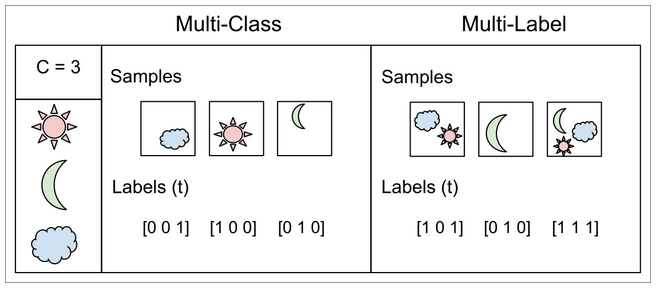

# Import Libraries

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

if not tf.config.list_physical_devices('GPU'):
    print('No GPU was detected. LSTMs and CNNs can be very slow without a GPU.')
    if IS_COLAB:
        print('Go to Runtime > Change runtime and select a GPU hardware accelerator.')

# Common imports
import os
import shutil
import itertools
import glob
import string
import pickle
import json
import re
import chardet

from bson import json_util

import numpy as np
import matplotlib.image as mpimg
import pandas as pd

from tqdm import tqdm
from time import time
from PIL import Image
from datetime import date


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

In [ ]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

# Paths to Data Directories

In [ ]:
BASE       = '/content'
DATA_PATH  = os.path.join( BASE, 'data')
IMG_DIR    = os.path.join( DATA_PATH, 'images' )

In [ ]:
if not os.path.exists(DATA_PATH):
  os.mkdir(DATA_PATH)

if not os.path.exists(IMG_DIR):
  os.mkdir(IMG_DIR)

# Data

In [ ]:
def tree_printer(root):
  for root, dirs, files in os.walk(root):
    for d in dirs:
      print( os.path.join(root, d) )
    # for f in files:
    #   print(os.path.join(root, f))
tree_printer(DATA_PATH)

/content/data/images


In [ ]:
def download_and_unzip(url, extract_to='.'):
  http_response = urlopen(url)
  zipfile = ZipFile(BytesIO(http_response.read()))
  zipfile.extractall(path=extract_to)

## Download Dataset

Dataset (images)

In [ ]:
movie_poster_url = 'https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/Movie_Poster_Dataset.zip'
download_and_unzip(movie_poster_url, extract_to=DATA_PATH)

Information text

In [ ]:
poster_text_url = 'https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/Movie_Poster_Metadata.zip'
download_and_unzip(poster_text_url, extract_to=DATA_PATH)

For each poster, the associated metadata are represented as follows. 

Meanings of metadata:

“_id” means the object ID of this movie on IMDB.

“Language” means the spoken language of this movie.

“Box_office” means the total box office of this movie.

“Country” means where the movie was released.

“Rated” means the rate of this movie, for example, “PG”, “R”.

“imdbID” means the ID of this movie from IMDB. This is the main ID we indicate aposter image. You can find the corresponding movie poster image with this ID.

“Awards” means the awards of this movie.

“Posters” means the original URL of this movie poster.

“Director” means the director of this movie.

“Released” means when this movie was released.

“Writer” means the writer of this movie.

“imdbVotes” means the votes of this movie on the IMDB website.

“Runtime” means the video length of this movie.

“Response” means whether there are someone response this movie or not.

“imdbRating” means the rating of this movie on the IMDB.

“Title” means the title of this movie.

“Genre” means the genres of this movie.

“Actors” means all the actors of this movie.

“Type” means the movie type, for example, “movie”, “series”
“Metascore” means the metascore of this movie. 

In [ ]:
DATA_DIR = os.path.join(DATA_PATH, 'Movie_Poster_Dataset')
META_DATA_DIR = os.path.join(DATA_PATH, 'groundtruth')
print('DATA_DIR : ', DATA_DIR)
print('META_DATA_DIR : ', META_DATA_DIR)

DATA_DIR :  /content/data/Movie_Poster_Dataset
META_DATA_DIR :  /content/data/groundtruth


Images

In [ ]:
folders = glob.glob(DATA_DIR+'/*')
print(len(folders))
folders[:3]

36


['/content/data/Movie_Poster_Dataset/2007',
 '/content/data/Movie_Poster_Dataset/2015',
 '/content/data/Movie_Poster_Dataset/2001']

In [ ]:
# Copy all images to /data/images
for i,folder in enumerate(folders):
  files = glob.glob(folder + '/*.jpg')
  if len(files) == 0:
    continue
  
  for filepath in files:
    shutil.move(filepath, IMG_DIR)

In [ ]:
all_images = glob.glob(IMG_DIR + '/*.jpg')
len(all_images)

8052

In [ ]:
shutil.rmtree(DATA_DIR)

Metadata

In [ ]:
txt_files = glob.glob(META_DATA_DIR+'/*')
print(len(txt_files))
txt_files[:10]

36


['/content/data/groundtruth/1984.txt',
 '/content/data/groundtruth/1993.txt',
 '/content/data/groundtruth/1985.txt',
 '/content/data/groundtruth/1989.txt',
 '/content/data/groundtruth/2015.txt',
 '/content/data/groundtruth/2009.txt',
 '/content/data/groundtruth/1990.txt',
 '/content/data/groundtruth/1995.txt',
 '/content/data/groundtruth/1981.txt',
 '/content/data/groundtruth/1983.txt']

## Metadata

In [ ]:
# Check content 
with open(META_DATA_DIR + '/1980.txt','r') as f:
  contents_1980 = f.read()
  contents_1980 = contents_1980.replace("\n  ", '').replace("\n", '').replace('}{"_id"', '}, {"_id"')
contents_1980

'{"_id" : ObjectId("56fb860e71a0651b0c306f55"),"Language" : "English","Box_office" : "290,158,751","Country" : "USA","Rated" : "PG","imdbID" : "tt0080684","Awards" : "Won 1 Oscar. Another 15 wins & 18 nominations.","Poster" : "http://ia.media-imdb.com/images/M/MV5BMjE2MzQwMTgxN15BMl5BanBnXkFtZTcwMDQzNjk2OQ@@._V1_SX300.jpg","Director" : "Irvin Kershner","Released" : "20 Jun 1980","Writer" : "Leigh Brackett (screenplay), Lawrence Kasdan (screenplay), George Lucas (story)","imdbVotes" : "799,579","Runtime" : "124 min","Response" : "True","imdbRating" : "8.8","Title" : "Star Wars: Episode V - The Empire Strikes Back","Genre" : "Action, Adventure, Fantasy","Actors" : "Mark Hamill, Harrison Ford, Carrie Fisher, Billy Dee Williams","Type" : "movie","Metascore" : "79"}, {"_id" : ObjectId("56fb860e71a0651b0c306f56"),"Language" : "English","Box_office" : "101,500,000","Country" : "USA","Rated" : "R","imdbID" : "tt0081562","Awards" : "1 nomination.","Poster" : "http://ia.media-imdb.com/images/M/M

In [ ]:
# Txt files and their encoding
encoding_infor = {}
for x in txt_files:
  f = open(x, "rb")
  code = chardet.detect(f.read())['encoding']
  encoding_infor[x] = code.lower()

encoding_infor

# {'/content/data/groundtruth/1980.txt': 'ascii',
#  '/content/data/groundtruth/1981.txt': 'ascii',
#  '/content/data/groundtruth/1982.txt': 'utf-16',

{'/content/data/groundtruth/1980.txt': 'ascii',
 '/content/data/groundtruth/1981.txt': 'ascii',
 '/content/data/groundtruth/1982.txt': 'utf-16',
 '/content/data/groundtruth/1983.txt': 'utf-16',
 '/content/data/groundtruth/1984.txt': 'utf-16',
 '/content/data/groundtruth/1985.txt': 'utf-16',
 '/content/data/groundtruth/1986.txt': 'utf-16',
 '/content/data/groundtruth/1987.txt': 'utf-16',
 '/content/data/groundtruth/1988.txt': 'utf-16',
 '/content/data/groundtruth/1989.txt': 'utf-16',
 '/content/data/groundtruth/1990.txt': 'utf-16',
 '/content/data/groundtruth/1991.txt': 'utf-16',
 '/content/data/groundtruth/1992.txt': 'utf-16',
 '/content/data/groundtruth/1993.txt': 'utf-16',
 '/content/data/groundtruth/1994.txt': 'utf-16',
 '/content/data/groundtruth/1995.txt': 'utf-16',
 '/content/data/groundtruth/1996.txt': 'utf-16',
 '/content/data/groundtruth/1997.txt': 'utf-16',
 '/content/data/groundtruth/1998.txt': 'utf-16',
 '/content/data/groundtruth/1999.txt': 'utf-16',
 '/content/data/ground

In [ ]:
# Read files and clean texts
with open(txt_files[0],'rb') as f:
  contents = f.read()
  contents = contents.decode( encoding_infor[txt_files[0]] )
  contents = contents.replace("\r\n  ", '').replace("\r\n", '').replace('}{"_id"', '}, {"_id"')
contents

'{"_id" : ObjectId("56fb965e71a0650fe43395e9"),"Response" : "True","Actors" : "Eddie Murphy, Judge Reinhold, John Ashton, Lisa Eilbacher","imdbID" : "tt0086960","Box_office" : "234,760,500","Director" : "Martin Brest","Writer" : "Daniel Petrie Jr. (screenplay), Danilo Bach (story), Daniel Petrie Jr. (story)","Awards" : "Nominated for 1 Oscar. Another 3 wins & 4 nominations.","Title" : "Beverly Hills Cop","Rated" : "R","imdbVotes" : "122,254","imdbRating" : "7.3","Type" : "movie","Genre" : "Action, Comedy, Crime","Released" : "05 Dec 1984","Poster" : "http://ia.media-imdb.com/images/M/MV5BNzMyMjQ2OTEwOF5BMl5BanBnXkFtZTgwNzc2OTkwMDE@._V1_SX300.jpg","Runtime" : "105 min","Metascore" : "64","Language" : "English","Country" : "USA"}, {"_id" : ObjectId("56fb965e71a0650fe43395ea"),"Response" : "True","Actors" : "Bill Murray, Dan Aykroyd, Sigourney Weaver, Harold Ramis","imdbID" : "tt0087332","Box_office" : "229,242,989","Director" : "Ivan Reitman","Writer" : "Dan Aykroyd, Harold Ramis","Award

In [ ]:
# Read mongo_ext_json file
def read_mongoextjson_file_ascii(file_path):
  with open(file_path,'r') as f:
    contents = f.read()
    contents = contents.replace("\n  ", '').replace("\n", '').replace('}{"_id"', '}, {"_id"')
  
  return contents



def read_mongoextjson_file_utf(file_path):
  with open(file_path,'rb') as f:
    contents = f.read()
    contents = contents.decode( 'utf-16' )
    contents = contents.replace("\r\n  ", '').replace("\r\n", '').replace('}{"_id"', '}, {"_id"')
  
  return contents

In [ ]:
def clean_json_string(contents):
  bsondata = '[' + contents + ']'

  # convert the TenGen JSON to Strict JSON
  # here, I just convert the ObjectId and Date structures,
  # but it's easy to extend to cover all structures listed at
  # http://www.mongodb.org/display/DOCS/Mongo+Extended+JSON
  # result = re.sub('abc',  'def', input) # Replace pattern abc -> def

  jsondata = re.sub(r'ObjectId\s*\(\s*\"(\S+)\"\s*\)',
                    r'{"$oid": "\1"}',
                    bsondata)
  jsondata = re.sub(r'ISODate\s*\(\s*(\S+)\s*\)',
                    r'{"$date": \1}',
                    jsondata)
  jsondata = re.sub(r'NumberInt\s*\(\s*(\S+)\s*\)',
                    r'{"$numberInt": "\1"}',
                    jsondata)

  # now we can parse this as JSON, and use MongoDB's object_hook
  # function to get rich Python data structures inside a dictionary
  data = json.loads(jsondata, object_hook=json_util.object_hook)

  return data

In [ ]:
# Read all metadata in to a list
combined_data = []
for i, xfile in enumerate(txt_files):
  print(i)
  if (encoding_infor[xfile] == 'ascii'):
    content_string = read_mongoextjson_file_ascii(xfile)

  if (encoding_infor[xfile] == 'utf-16'):
    content_string = read_mongoextjson_file_utf(xfile)

  data = clean_json_string(content_string)
  combined_data = combined_data + data
# End

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [ ]:
len(combined_data)

8873

In [ ]:
# Metadata to dataframe
df = pd.DataFrame(combined_data)
df.head(4)

,_id,Response,Actors,imdbID,Box_office,Director,Writer,Awards,Title,Rated,imdbVotes,imdbRating,Type,Genre,Released,Poster,Runtime,Metascore,Language,Country
0,56fb965e71a0650fe43395e9,True,"Eddie Murphy, Judge Reinhold, John Ashton, Lis...",tt0086960,"234,760,500",Martin Brest,"Daniel Petrie Jr. (screenplay), Danilo Bach (s...",Nominated for 1 Oscar. Another 3 wins & 4 nomi...,Beverly Hills Cop,R,"122,254",7.3,movie,"Action, Comedy, Crime",05 Dec 1984,http://ia.media-imdb.com/images/M/MV5BNzMyMjQ2...,105 min,64,English,USA
1,56fb965e71a0650fe43395ea,True,"Bill Murray, Dan Aykroyd, Sigourney Weaver, Ha...",tt0087332,"229,242,989",Ivan Reitman,"Dan Aykroyd, Harold Ramis",Nominated for 2 Oscars. Another 5 wins & 6 nom...,Ghostbusters,PG,"252,631",7.8,movie,"Adventure, Comedy, Fantasy",08 Jun 1984,http://ia.media-imdb.com/images/M/MV5BMTkxMjYy...,105 min,67,English,USA
2,56fb965e71a0650fe43395eb,True,"Harrison Ford, Kate Capshaw, Jonathan Ke Quan,...",tt0087469,"179,870,271",Steven Spielberg,"Willard Huyck (screenplay), Gloria Katz (scree...",Won 1 Oscar. Another 6 wins & 20 nominations.,Indiana Jones and the Temple of Doom,PG,"315,789",7.6,movie,"Action, Adventure",23 May 1984,http://ia.media-imdb.com/images/M/MV5BMTMyNzI4...,118 min,57,"English, Sinhalese",USA
3,56fb965e71a0650fe43395ec,True,"Hoyt Axton, John Louie, Keye Luke, Don Steele",tt0087363,"148,170,000",Joe Dante,Chris Columbus,7 wins & 6 nominations.,Gremlins,PG,"135,208",7.2,movie,"Comedy, Fantasy, Horror",08 Jun 1984,http://ia.media-imdb.com/images/M/MV5BMTU4Njk2...,106 min,N/A,"English, Spanish",USA


In [ ]:
# Number of rows and columns (rows, cols)
df.shape

(8873, 20)

In [ ]:
# Print feature names
df.columns

Index(['_id', 'Response', 'Actors', 'imdbID', 'Box_office', 'Director',
       'Writer', 'Awards', 'Title', 'Rated', 'imdbVotes', 'imdbRating', 'Type',
       'Genre', 'Released', 'Poster', 'Runtime', 'Metascore', 'Language',
       'Country'],
      dtype='object')

In [ ]:
# Type of each column
df.dtypes

_id           object
Response      object
Actors        object
imdbID        object
Box_office    object
Director      object
Writer        object
Awards        object
Title         object
Rated         object
imdbVotes     object
imdbRating    object
Type          object
Genre         object
Released      object
Poster        object
Runtime       object
Metascore     object
Language      object
Country       object
dtype: object

In [ ]:
df['imdbID'].value_counts()

tt0337978    2
tt0300532    2
tt0102315    2
tt0437179    2
tt2546294    2
            ..
tt0461936    1
tt0145394    1
tt0371939    1
tt0094799    1
tt0475998    1
Name: imdbID, Length: 8861, dtype: int64

In [ ]:
# Print unique values to check the consitency
print(len(df['imdbID'].unique()))
print(len(df['Title'].unique()))
print(len(df['_id'].unique()))

8861
8843
8873


In [ ]:
df[ df['imdbID'] == 'tt0337978' ]

,_id,Response,Actors,imdbID,Box_office,Director,Writer,Awards,Title,Rated,imdbVotes,imdbRating,Type,Genre,Released,Poster,Runtime,Metascore,Language,Country
2211,5707203271a0650af414df02,True,"Bruce Willis, Timothy Olyphant, Justin Long, M...",tt0337978,"134,520,804",Len Wiseman,"Mark Bomback (screenplay), Mark Bomback (story...",3 wins & 16 nominations.,Live Free or Die Hard,PG-13,"329,631",7.2,movie,"Action, Adventure, Thriller",27 Jun 2007,http://ia.media-imdb.com/images/M/MV5BNDQxMDE1...,128 min,69,"English, Italian, French","USA, UK"
2524,5707203271a0650af414e03b,True,"Bruce Willis, Timothy Olyphant, Justin Long, M...",tt0337978,"134,520,804",Len Wiseman,"Mark Bomback (screenplay), Mark Bomback (story...",3 wins & 16 nominations.,Live Free or Die Hard,PG-13,"329,631",7.2,movie,"Action, Adventure, Thriller",27 Jun 2007,http://ia.media-imdb.com/images/M/MV5BNDQxMDE1...,128 min,69,"English, Italian, French","USA, UK"


In [ ]:
# Check number of items before dropping duplicates
df.shape

(8873, 20)

In [ ]:
# drop duplicates
cleaned_df = df.drop_duplicates(subset=['imdbID'], keep='first')

In [ ]:
# Check number of items after dropping duplicates
cleaned_df.shape

(8861, 20)

In [ ]:
len(cleaned_df['imdbID'].unique())

8861

In [ ]:
cleaned_df[ cleaned_df['imdbID'] == 'tt0337978' ]

,_id,Response,Actors,imdbID,Box_office,Director,Writer,Awards,Title,Rated,imdbVotes,imdbRating,Type,Genre,Released,Poster,Runtime,Metascore,Language,Country
2211,5707203271a0650af414df02,True,"Bruce Willis, Timothy Olyphant, Justin Long, M...",tt0337978,"134,520,804",Len Wiseman,"Mark Bomback (screenplay), Mark Bomback (story...",3 wins & 16 nominations.,Live Free or Die Hard,PG-13,"329,631",7.2,movie,"Action, Adventure, Thriller",27 Jun 2007,http://ia.media-imdb.com/images/M/MV5BNDQxMDE1...,128 min,69,"English, Italian, French","USA, UK"


In [ ]:
# So, number of unique items in metadata:
print('Number of unique items in metadata:')
cleaned_df.shape[0]

Number of unique items in metadata:


8861

## All images

In [ ]:
all_images = glob.glob(IMG_DIR + '/*')
print('Number of images: ', len(all_images) )
all_images[:3]

Number of images:  8052


['/content/data/images/tt2883512.jpg',
 '/content/data/images/tt1736672.jpg',
 '/content/data/images/tt1430132.jpg']

In [ ]:
imdbID = [x.split('/')[-1].split('.')[0] for x in all_images]
print('Number of imdbIds: ', len(imdbID) )
imdbID[:3]

Number of imdbIds:  8052


['tt2883512', 'tt1736672', 'tt1430132']

Image shape:  (445, 300, 3)


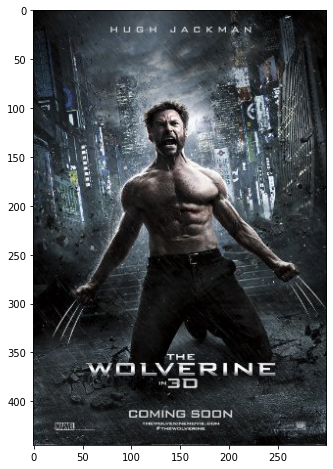

In [ ]:
# Plot an image
some_id = imdbID.index('tt1430132')
plt.figure(figsize=(8,8))
img = mpimg.imread(all_images[some_id])
plt.imshow( img )

print('Image shape: ', img.shape)

plt.show()

Check if imdbID list contains any duplicate element:

In [ ]:
def check_duplicates(x: list) -> bool:
  ''' Check if given list contains any duplicates '''    
  s = set()
  for elem in x:
    if elem in s:
      return True
    else:
      s.add(elem)         
  return False

In [ ]:
check_duplicates(imdbID)

False

imdbID list does not contain duplicate element. So, the number of unique images is:

In [ ]:
print("Number of unique images: ", len(imdbID))

Number of unique images:  8052


In [ ]:
# selecting rows based on condition
rslt_df = cleaned_df[cleaned_df['imdbID'].isin(imdbID)]
rslt_df.head(2)

,_id,Response,Actors,imdbID,Box_office,Director,Writer,Awards,Title,Rated,imdbVotes,imdbRating,Type,Genre,Released,Poster,Runtime,Metascore,Language,Country
0,56fb965e71a0650fe43395e9,True,"Eddie Murphy, Judge Reinhold, John Ashton, Lis...",tt0086960,"234,760,500",Martin Brest,"Daniel Petrie Jr. (screenplay), Danilo Bach (s...",Nominated for 1 Oscar. Another 3 wins & 4 nomi...,Beverly Hills Cop,R,"122,254",7.3,movie,"Action, Comedy, Crime",05 Dec 1984,http://ia.media-imdb.com/images/M/MV5BNzMyMjQ2...,105 min,64,English,USA
1,56fb965e71a0650fe43395ea,True,"Bill Murray, Dan Aykroyd, Sigourney Weaver, Ha...",tt0087332,"229,242,989",Ivan Reitman,"Dan Aykroyd, Harold Ramis",Nominated for 2 Oscars. Another 5 wins & 6 nom...,Ghostbusters,PG,"252,631",7.8,movie,"Adventure, Comedy, Fantasy",08 Jun 1984,http://ia.media-imdb.com/images/M/MV5BMTkxMjYy...,105 min,67,English,USA


In [ ]:
rslt_df.shape

(8052, 20)

In [ ]:
rslt_df[ rslt_df['imdbID'] == 'tt1273678' ]

,_id,Response,Actors,imdbID,Box_office,Director,Writer,Awards,Title,Rated,imdbVotes,imdbRating,Type,Genre,Released,Poster,Runtime,Metascore,Language,Country
8160,57073cbc71a06515609398cf,True,"Jackie Chan, Amber Valletta, Madeline Carroll,...",tt1273678,None,Brian Levant,"Jonathan Bernstein (screenplay), James Greer (...",2 nominations.,The Spy Next Door,PG,"28,886",5.4,movie,"Action, Comedy, Family",15 Jan 2010,http://ia.media-imdb.com/images/M/MV5BMTI5MjEz...,94 min,27,English,USA


In [ ]:
rslt_df.isnull().sum()

_id              0
Response         0
Actors           0
imdbID           0
Box_office    2065
Director         0
Writer           0
Awards           0
Title            0
Rated            0
imdbVotes        0
imdbRating       0
Type             0
Genre            0
Released         0
Poster           0
Runtime          0
Metascore        0
Language         0
Country          0
dtype: int64

In [ ]:
# Box_office may be not an important feature, I'll drop it
rslt_df = rslt_df.drop(['Box_office'], axis=1)
rslt_df.columns

Index(['_id', 'Response', 'Actors', 'imdbID', 'Director', 'Writer', 'Awards',
       'Title', 'Rated', 'imdbVotes', 'imdbRating', 'Type', 'Genre',
       'Released', 'Poster', 'Runtime', 'Metascore', 'Language', 'Country'],
      dtype='object')

Check NULL values again

In [ ]:
rslt_df.isnull().sum()

_id           0
Response      0
Actors        0
imdbID        0
Director      0
Writer        0
Awards        0
Title         0
Rated         0
imdbVotes     0
imdbRating    0
Type          0
Genre         0
Released      0
Poster        0
Runtime       0
Metascore     0
Language      0
Country       0
dtype: int64

In [ ]:
rslt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8052 entries, 0 to 8871
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   _id         8052 non-null   object
 1   Response    8052 non-null   object
 2   Actors      8052 non-null   object
 3   imdbID      8052 non-null   object
 4   Director    8052 non-null   object
 5   Writer      8052 non-null   object
 6   Awards      8052 non-null   object
 7   Title       8052 non-null   object
 8   Rated       8052 non-null   object
 9   imdbVotes   8052 non-null   object
 10  imdbRating  8052 non-null   object
 11  Type        8052 non-null   object
 12  Genre       8052 non-null   object
 13  Released    8052 non-null   object
 14  Poster      8052 non-null   object
 15  Runtime     8052 non-null   object
 16  Metascore   8052 non-null   object
 17  Language    8052 non-null   object
 18  Country     8052 non-null   object
dtypes: object(19)
memory usage: 1.2+ MB


## Plot some images

In [ ]:
all_images[:3]

['/content/data/images/tt2883512.jpg',
 '/content/data/images/tt1736672.jpg',
 '/content/data/images/tt1430132.jpg']

Image shape:  (441, 300, 3)
Image shape:  (300, 300, 3)
Image shape:  (445, 300, 3)
Image shape:  (444, 300, 3)
Image shape:  (444, 300, 3)
Image shape:  (477, 300, 3)
Image shape:  (423, 300, 3)
Image shape:  (464, 300, 3)
Image shape:  (444, 300, 3)


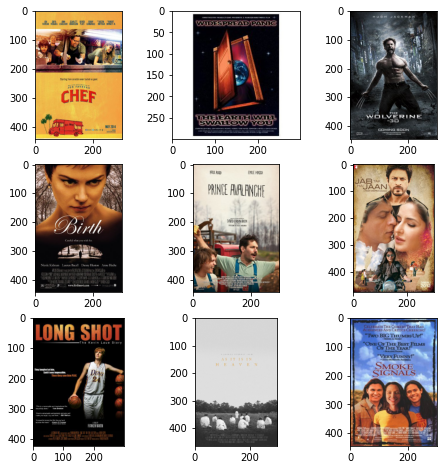

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(8,8))
axs = axs.flatten()

for i in range(9):
  ax = axs[i]
  img = mpimg.imread(all_images[i])
  ax.imshow( img )

  print('Image shape: ', img.shape)

plt.show()

# 5. Data Wrangling

1. Since data is in form of excel file we have to use pandas read_excel to load the data.

2. After loading it is important to check the complete information of data as it can indication many of the hidden infomation such as null values in a column or a row

3. Check whether any null values are there or not. if it is present then following can be done:



> a. Imputing data using Imputation method in sklearn


> b. Filling NaN values with mean, median and mode using fillna() method

4. Describe data --> which can give statistical analysis

In [ ]:
# rslt_df.reset_index()
rslt_df.head(2)

,_id,Response,Actors,imdbID,Director,Writer,Awards,Title,Rated,imdbVotes,imdbRating,Type,Genre,Released,Poster,Runtime,Metascore,Language,Country
0,56fb965e71a0650fe43395e9,True,"Eddie Murphy, Judge Reinhold, John Ashton, Lis...",tt0086960,Martin Brest,"Daniel Petrie Jr. (screenplay), Danilo Bach (s...",Nominated for 1 Oscar. Another 3 wins & 4 nomi...,Beverly Hills Cop,R,"122,254",7.3,movie,"Action, Comedy, Crime",05 Dec 1984,http://ia.media-imdb.com/images/M/MV5BNzMyMjQ2...,105 min,64,English,USA
1,56fb965e71a0650fe43395ea,True,"Bill Murray, Dan Aykroyd, Sigourney Weaver, Ha...",tt0087332,Ivan Reitman,"Dan Aykroyd, Harold Ramis",Nominated for 2 Oscars. Another 5 wins & 6 nom...,Ghostbusters,PG,"252,631",7.8,movie,"Adventure, Comedy, Fantasy",08 Jun 1984,http://ia.media-imdb.com/images/M/MV5BMTkxMjYy...,105 min,67,English,USA


## Title

In [ ]:
# print("Title: ", rslt_df.Title.unique())
print("No. of Title: ", len(rslt_df.Title.unique()) )
print()
rslt_df.Title.value_counts()

No. of Title:  8040



Revolution             2
Daniel                 2
No Escape              2
The Karate Kid         2
Running Scared         2
                      ..
Muppets Most Wanted    1
The Crazies            1
You're Not You         1
The Patriot            1
When We Were Kings     1
Name: Title, Length: 8040, dtype: int64

In [ ]:
for title in rslt_df.Title.unique():
  if len(title) < 4:
    print(title)

CB4
Ran
K-9
Dad
Tap
UHF
Spy
Joy
Pan
Amy
Up
Paa
War
P2
Zoo
PK
PCU
54
Woo
Pi
Rio
Hop
Bol
Jig
Now
F/X
Rad
42
JFK
Run
Ted
ATM
21
W.
CJ7
8MM
Go
Ray
Saw
Dev
Ali
Big
Da
15
RV
ATL
Don
xXx
Max
RED
Ed
Elf
Dum


In [ ]:
rslt_df[ rslt_df.Title == 'N/A' ]

,_id,Response,Actors,imdbID,Director,Writer,Awards,Title,Rated,imdbVotes,imdbRating,Type,Genre,Released,Poster,Runtime,Metascore,Language,Country


No invalid titles

## Actors

In [ ]:
# print("Actors: ", rslt_df.Actors.unique())
print("No. of Actors: ", len(rslt_df.Actors.unique()) )
print()
rslt_df.Actors.value_counts()

No. of Actors:  7957



N/A                                                               57
Patrick Stewart, Jonathan Frakes, Brent Spiner, LeVar Burton       4
William Shatner, Leonard Nimoy, DeForest Kelley, James Doohan      4
Bradley Cooper, Ed Helms, Zach Galifianakis, Justin Bartha         3
Ian McKellen, Martin Freeman, Richard Armitage, Ken Stott          3
                                                                  ..
Daniel Day-Lewis, Daragh Donnelly, Frank Coughlan, Sean Kearns     1
DJ Qualls, Eliza Dushku, Zooey Deschanel, Jerod Mixon              1
Alec Baldwin, Geena Davis, Annie McEnroe, Maurice Page             1
Vin Diesel, Lauren Graham, Faith Ford, Brittany Snow               1
Edward Albert, Ellen Barber, Timothy Carhart, James Cromwell       1
Name: Actors, Length: 7957, dtype: int64

In [ ]:
for val in rslt_df.Actors.unique():
  if len(val) < 5:
    print(val)

N/A


In [ ]:
rslt_df[ rslt_df.Actors == 'N/A' ].shape

(57, 19)

There are 57 movies missing details of actors.

## Director

In [ ]:
print("No. of Director: ", len(rslt_df.Director.unique()) )
print()
rslt_df.Director.value_counts()

No. of Director:  4056



Woody Allen          32
Clint Eastwood       25
N/A                  24
Steven Spielberg     23
Spike Lee            21
                     ..
Bobby Roth            1
Eric Bay-Andersen     1
Eugene Levy           1
Dan Aykroyd           1
Peter Horton          1
Name: Director, Length: 4056, dtype: int64

In [ ]:
for val in rslt_df.Director.unique():
  if len(val) < 4:
    print(val)

N/A
McG
RZA
BT


In [ ]:
rslt_df[ rslt_df.Director == 'N/A' ].shape

(24, 19)

There are 24 movies missing the details of Directors.

## Country

In [ ]:
print("No. of Country: ", len(rslt_df.Country.unique()) )
print()
rslt_df.Country.value_counts()

No. of Country:  656



USA                                  5173
India                                 306
UK, USA                               209
UK                                    189
USA, UK                               147
                                     ... 
USA, Portugal, Spain                    1
USA, Bhutan, India, France, Nepal       1
USA, Japan, Argentina, Costa Rica       1
Israel, Denmark, USA, Austria           1
UK, Germany, USA, Canada                1
Name: Country, Length: 656, dtype: int64

In [ ]:
for val in rslt_df.Country.unique():
  if len(val) < 5:
    print(val)

USA
UK
N/A
Iran


In [ ]:
rslt_df[ rslt_df.Country == 'N/A' ].shape

(5, 19)

There are 5 movies missing the details of Country.

## imdbRating

In [ ]:
print("No. of imdbRating: ", len(rslt_df.imdbRating.unique()) )
print()
rslt_df.imdbRating.value_counts()

No. of imdbRating:  80



6.4    342
6.5    324
6.7    321
6.6    311
6.3    292
      ... 
9.2      2
1.6      1
1.8      1
9.6      1
1.1      1
Name: imdbRating, Length: 80, dtype: int64

In [ ]:
# Number of item missing details of ...
rslt_df[ rslt_df.imdbRating == 'N/A' ].shape

(32, 19)

In [ ]:
na_idx = rslt_df[ rslt_df.imdbRating == 'N/A' ].index
rslt_df.loc[na_idx, ['imdbRating'] ] = "0"

In [ ]:
rslt_df['imdbRating'] = rslt_df['imdbRating'].astype(float)

In [ ]:
rslt_df['imdbRating'].describe()

count    8052.000000
mean        6.260606
std         1.155228
min         0.000000
25%         5.600000
50%         6.400000
75%         7.100000
max         9.600000
Name: imdbRating, dtype: float64

## Released

In [ ]:
print("No. of Released: ", len(rslt_df.Released.unique()) )
print()
rslt_df.Released.value_counts()

No. of Released:  2982



N/A            57
21 Sep 2012    13
06 Sep 2013    12
10 Oct 2008    12
30 Sep 2011    11
               ..
01 Jan 2014     1
29 Aug 2007     1
16 Mar 2002     1
11 Jun 1993     1
31 May 1985     1
Name: Released, Length: 2982, dtype: int64

In [ ]:
for val in rslt_df.Released.unique():
  if len(val) < 4:
    print(val)

N/A


In [ ]:
# Number of movies missing details of ...
rslt_df[ rslt_df.Released == 'N/A' ].shape

(57, 19)

In [ ]:
# rslt_df['Released'] = pd.to_datetime(rslt_df['Released'])
# rslt_df['Released'] 

## Rated

In [ ]:
print("No. of Rated: ", len(rslt_df.Rated.unique()) )
print()
rslt_df.Rated.value_counts()

No. of Rated:  17



R            3287
PG-13        2020
PG           1208
N/A           955
NOT RATED     262
G             167
UNRATED       119
NC-17          15
X               7
TV-MA           4
TV-14           2
Not Rated       1
AO              1
TV-PG           1
M/PG            1
PASSED          1
TV-G            1
Name: Rated, dtype: int64

In [ ]:
for val in rslt_df.Rated.unique():
  if len(val) < 4:
    print(val)

R
PG
G
N/A
X
AO


In [ ]:
na_idx = rslt_df[ rslt_df.Rated == 'N/A' ].index

In [ ]:
rslt_df.loc[na_idx, ['Rated'] ] = "UNRATED"

In [ ]:
na_idx = rslt_df[ rslt_df.Rated == 'NOT RATED' ].index
rslt_df.loc[na_idx, ['Rated'] ] = "UNRATED"

In [ ]:
print("No. of Rated: ", len(rslt_df.Rated.unique()) )
print()
rslt_df.Rated.value_counts()

No. of Rated:  15



R            3287
PG-13        2020
UNRATED      1336
PG           1208
G             167
NC-17          15
X               7
TV-MA           4
TV-14           2
TV-PG           1
Not Rated       1
AO              1
M/PG            1
PASSED          1
TV-G            1
Name: Rated, dtype: int64

## Language

In [ ]:
print("No. of Language: ", len(rslt_df.Language.unique()) )
print()
rslt_df.Language.value_counts()

No. of Language:  755



English                                      5579
English, Spanish                              316
Hindi                                         191
English, French                               178
English, Italian                               68
                                             ... 
English, German, Russian, French                1
English, Malay, Indonesian                      1
English, Guarani, Spanish, Latin                1
French, English, Persian, German                1
English, German, Russian, French, Flemish       1
Name: Language, Length: 755, dtype: int64

In [ ]:
for val in rslt_df.Language.unique():
  if len(val) < 5:
    print(val)

N/A
Urdu
Maya


In [ ]:
# Number of movies missing details of....
rslt_df[ rslt_df.Language == 'N/A' ].shape

(23, 19)

## Genre

In [ ]:
print("No. of Genre: ", len(rslt_df.Genre.unique()) )
print()
rslt_df.Genre.value_counts()

No. of Genre:  585



Drama                           520
Comedy                          467
Comedy, Drama                   370
Comedy, Drama, Romance          364
Documentary                     330
                               ... 
Comedy, Musical, Adventure        1
Adventure, Animation, Sci-Fi      1
Biography, Comedy, Romance        1
Adventure, Biography              1
Action, Mystery, Romance          1
Name: Genre, Length: 585, dtype: int64

In [ ]:
for val in rslt_df.Genre.unique():
  if len(val) < 5:
    print(val)

N/A
War


In [ ]:
# Number of movies missing details of ....
rslt_df[ rslt_df.Genre == 'N/A' ].shape

(11, 19)

## Metascore

In [ ]:
print("No. of Metascore: ", len(rslt_df.Metascore.unique()) )
print()
rslt_df.Metascore.value_counts()

No. of Metascore:  97



N/A    3287
55      105
65      102
51      100
45      100
       ... 
10        2
5         1
97        1
100       1
6         1
Name: Metascore, Length: 97, dtype: int64

In [ ]:
for val in rslt_df.Metascore.unique():
  if len(val) >= 3:
    print(val)

N/A
100


In [ ]:
# Number of movies missing details of ...
rslt_df[ rslt_df.Metascore == 'N/A' ].shape

(3287, 19)

In [ ]:
na_idx = rslt_df[ rslt_df.Metascore == 'N/A' ].index
rslt_df.loc[na_idx, ['Metascore'] ] = "0"

In [ ]:
rslt_df[ rslt_df.Metascore == 'N/A' ]

,_id,Response,Actors,imdbID,Director,Writer,Awards,Title,Rated,imdbVotes,imdbRating,Type,Genre,Released,Poster,Runtime,Metascore,Language,Country


In [ ]:
rslt_df['Metascore'] = rslt_df['Metascore'].astype(float)

## imdbVotes

In [ ]:
print("No. of imdbVotes: ", len(rslt_df.imdbVotes.unique()) )
print()
rslt_df.imdbVotes.value_counts()

No. of imdbVotes:  6810



N/A       33
8          7
63         7
7          7
56         7
          ..
15,776     1
92,290     1
15,036     1
51,558     1
48,347     1
Name: imdbVotes, Length: 6810, dtype: int64

In [ ]:
rslt_df['imdbVotes'] = rslt_df['imdbVotes'].apply(lambda x: x.replace(',', ''))

In [ ]:
print("No. of imdbVotes: ", len(rslt_df.imdbVotes.unique()) )
print()
rslt_df.imdbVotes.value_counts()

No. of imdbVotes:  6810



N/A       33
56         7
63         7
7          7
8          7
          ..
6455       1
10240      1
47073      1
6762       1
120427     1
Name: imdbVotes, Length: 6810, dtype: int64

In [ ]:
# Number of movies missing details of ...
rslt_df[ rslt_df.imdbVotes == 'N/A' ].shape

(33, 19)

In [ ]:
na_idx = rslt_df[ rslt_df.imdbVotes == 'N/A' ].index
rslt_df.loc[na_idx, ['imdbVotes'] ] = "0"

In [ ]:
rslt_df[ rslt_df.Metascore == 'N/A' ]

,_id,Response,Actors,imdbID,Director,Writer,Awards,Title,Rated,imdbVotes,imdbRating,Type,Genre,Released,Poster,Runtime,Metascore,Language,Country


In [ ]:
rslt_df['imdbVotes'] = rslt_df['imdbVotes'].astype(float)

In [ ]:
rslt_df['imdbVotes'].describe()

count    8.052000e+03
mean     4.714155e+04
std      1.044180e+05
min      0.000000e+00
25%      1.777250e+03
50%      9.438000e+03
75%      4.432725e+04
max      1.626900e+06
Name: imdbVotes, dtype: float64

## Awards

In [ ]:
print("No. of Awards: ", len(rslt_df.Awards.unique()) )
print()
rslt_df.Awards.value_counts()

No. of Awards:  1538



N/A                                                                2148
1 nomination.                                                       755
2 nominations.                                                      344
1 win.                                                              258
1 win & 1 nomination.                                               238
                                                                   ... 
Nominated for 1 Oscar. Another 12 wins & 7 nominations.               1
Nominated for 1 Golden Globe. Another 83 wins & 92 nominations.       1
Nominated for 1 Golden Globe. Another 4 wins & 32 nominations.        1
Won 7 Oscars. Another 69 wins & 33 nominations.                       1
Nominated for 1 Golden Globe. Another 15 wins & 24 nominations.       1
Name: Awards, Length: 1538, dtype: int64

In [ ]:
for val in rslt_df.Awards.unique():
  if len(val) < 4:
    print(val)

N/A


In [ ]:
# Number of movies missing details of ...
rslt_df[ rslt_df.Awards == 'N/A' ].shape

(2148, 19)

In [ ]:
na_idx = rslt_df[ rslt_df.Awards == 'N/A' ].index
rslt_df.loc[na_idx, ['Awards'] ] = ""

In [ ]:
rslt_df[ rslt_df.Awards == 'N/A' ]

,_id,Response,Actors,imdbID,Director,Writer,Awards,Title,Rated,imdbVotes,imdbRating,Type,Genre,Released,Poster,Runtime,Metascore,Language,Country


## Writer

In [ ]:
print("No. of Writers: ", len(rslt_df.Writer.unique()) )
print()
rslt_df.Writer.value_counts()

No. of Writers:  6900



N/A                                                                             376
Woody Allen                                                                      30
John Hughes                                                                      18
John Sayles                                                                      13
Joe Eszterhas                                                                     9
                                                                               ... 
Matthew A. Cherry                                                                 1
Rosalind Wiseman (book), Tina Fey (screenplay)                                    1
Norman Snider                                                                     1
Ann Guedes (screenplay), Frank McGuinness (screenplay), Kate O'Brien (novel)      1
Richard Dowlearn, Christian Fry                                                   1
Name: Writer, Length: 6900, dtype: int64

In [ ]:
for val in rslt_df.Writer.unique():
  if len(val) < 4:
    print(val)

N/A


In [ ]:
na_idx = rslt_df[ rslt_df.Writer == 'N/A' ].index
rslt_df.loc[na_idx, ['Writer'] ] = ""

In [ ]:
rslt_df[ rslt_df.Writer == 'N/A' ]

,_id,Response,Actors,imdbID,Director,Writer,Awards,Title,Rated,imdbVotes,imdbRating,Type,Genre,Released,Poster,Runtime,Metascore,Language,Country


## Type

In [ ]:
print("No. of Types: ", len(rslt_df.Type.unique()) )
print()
rslt_df.Type.value_counts()

No. of Types:  3



movie     8034
series      16
game         2
Name: Type, dtype: int64

In [ ]:
for val in rslt_df.Type.unique():
  if len(val) < 4:
    print(val)

In [ ]:
rslt_df[ rslt_df.Type == 'N/A' ]

,_id,Response,Actors,imdbID,Director,Writer,Awards,Title,Rated,imdbVotes,imdbRating,Type,Genre,Released,Poster,Runtime,Metascore,Language,Country


In [ ]:
rslt_df['Type'].value_counts()

movie     8034
series      16
game         2
Name: Type, dtype: int64

## Poster

In [ ]:
print("No. of Posters: ", len(rslt_df.Poster.unique()) )
print()
rslt_df.Poster.value_counts()

No. of Posters:  8050



http://ia.media-imdb.com/images/M/MV5BMTQ4MDk0OTA0OV5BMl5BanBnXkFtZTcwMzY1ODc4Mw@@._V1_SX300.jpg    2
http://ia.media-imdb.com/images/M/MV5BMTI3MzE1NTU1M15BMl5BanBnXkFtZTcwNzg1NTA0MQ@@._V1_SX300.jpg    2
http://ia.media-imdb.com/images/M/MV5BMTQ4ODE3ODEyMl5BMl5BanBnXkFtZTYwNTYwOTk2._V1_SX300.jpg        1
http://ia.media-imdb.com/images/M/MV5BMTIwMTc1MDQ1Nl5BMl5BanBnXkFtZTcwNDk3NzcyMQ@@._V1_SX300.jpg    1
http://ia.media-imdb.com/images/M/MV5BMTI1Mjc3MzM1NF5BMl5BanBnXkFtZTcwMDcwMzczMQ@@._V1_SX300.jpg    1
                                                                                                   ..
http://ia.media-imdb.com/images/M/MV5BMTc3NDEzMTM2MF5BMl5BanBnXkFtZTcwMDkxMzQyMQ@@._V1_SX300.jpg    1
http://ia.media-imdb.com/images/M/MV5BMTI4NjgxODE3MV5BMl5BanBnXkFtZTYwNjMyMjU5._V1_SX300.jpg        1
http://ia.media-imdb.com/images/M/MV5BMjE0NDE2MDI2MF5BMl5BanBnXkFtZTgwOTU2Mzk5MDE@._V1_SX300.jpg    1
http://ia.media-imdb.com/images/M/MV5BMjI5MTg1Njg0Ml5BMl5BanBnXkFtZTcwNzg2Mjc4Nw@@

In [ ]:
for val in rslt_df.Poster.unique():
  if len(val) < 4:
    print(val)

In [ ]:
rslt_df[ rslt_df.Poster == 'N/A' ]

,_id,Response,Actors,imdbID,Director,Writer,Awards,Title,Rated,imdbVotes,imdbRating,Type,Genre,Released,Poster,Runtime,Metascore,Language,Country


## Runtime

In [ ]:
print("No. of Runtimes: ", len(rslt_df.Runtime.unique()) )
print()
rslt_df.Runtime.value_counts()

No. of Runtimes:  199



90 min     294
97 min     245
95 min     244
93 min     227
96 min     226
          ... 
7 min        1
61 min       1
57 min       1
219 min      1
4 min        1
Name: Runtime, Length: 199, dtype: int64

In [ ]:
for val in rslt_df.Runtime.unique():
  if len(val) < 4:
    print(val)

N/A


In [ ]:
# Number of movies missing deatils of Runtime
rslt_df[ rslt_df.Runtime == 'N/A' ].shape

(66, 19)

In [ ]:
na_idx = rslt_df[ rslt_df.Runtime == 'N/A' ].index
rslt_df.loc[na_idx, ['Runtime'] ] = "0 min"

In [ ]:
rslt_df['Runtime'] = rslt_df['Runtime'].apply(lambda x: x.replace(' min', ''))

In [ ]:
na_idx = rslt_df[ rslt_df.Runtime == '' ].index
rslt_df.loc[na_idx, ['Runtime'] ] = "0"

In [ ]:
rslt_df['Runtime'] = rslt_df['Runtime'].astype(float)

In [ ]:
print("No. of Runtimes: ", len(rslt_df.Runtime.unique()) )
print()
rslt_df.Runtime.value_counts()

No. of Runtimes:  199



90.0     294
97.0     245
95.0     244
93.0     227
96.0     226
        ... 
334.0      1
63.0       1
244.0      1
19.0       1
210.0      1
Name: Runtime, Length: 199, dtype: int64

## Response

In [ ]:
print("No. of Responses: ", len(rslt_df.Response.unique()) )
print()
rslt_df.Response.value_counts()

No. of Responses:  1



True    8052
Name: Response, dtype: int64

In [ ]:
for val in rslt_df.Response.unique():
  if len(val) < 4:
    print(val)

In [ ]:
rslt_df[ rslt_df.Response == 'N/A' ]

,_id,Response,Actors,imdbID,Director,Writer,Awards,Title,Rated,imdbVotes,imdbRating,Type,Genre,Released,Poster,Runtime,Metascore,Language,Country


# Genre of movies

In [ ]:
rslt_df.shape

(8052, 19)

In [ ]:
# Number of movies missing details of ....
rslt_df[ rslt_df.Genre == 'N/A' ].shape

(11, 19)

In [ ]:
rslt_df[ rslt_df.Genre != 'N/A' ].shape

(8041, 19)

We have 8082 movies in total. 11 movies are missing detail of Genre. I'll remove them.

In [ ]:
final_df = rslt_df[ rslt_df.Genre != 'N/A' ]
final_df.shape

(8041, 19)

In [ ]:
final_df.head()

,_id,Response,Actors,imdbID,Director,Writer,Awards,Title,Rated,imdbVotes,imdbRating,Type,Genre,Released,Poster,Runtime,Metascore,Language,Country
0,56fb965e71a0650fe43395e9,True,"Eddie Murphy, Judge Reinhold, John Ashton, Lis...",tt0086960,Martin Brest,"Daniel Petrie Jr. (screenplay), Danilo Bach (s...",Nominated for 1 Oscar. Another 3 wins & 4 nomi...,Beverly Hills Cop,R,122254.0,7.3,movie,"Action, Comedy, Crime",05 Dec 1984,http://ia.media-imdb.com/images/M/MV5BNzMyMjQ2...,105.0,64.0,English,USA
1,56fb965e71a0650fe43395ea,True,"Bill Murray, Dan Aykroyd, Sigourney Weaver, Ha...",tt0087332,Ivan Reitman,"Dan Aykroyd, Harold Ramis",Nominated for 2 Oscars. Another 5 wins & 6 nom...,Ghostbusters,PG,252631.0,7.8,movie,"Adventure, Comedy, Fantasy",08 Jun 1984,http://ia.media-imdb.com/images/M/MV5BMTkxMjYy...,105.0,67.0,English,USA
2,56fb965e71a0650fe43395eb,True,"Harrison Ford, Kate Capshaw, Jonathan Ke Quan,...",tt0087469,Steven Spielberg,"Willard Huyck (screenplay), Gloria Katz (scree...",Won 1 Oscar. Another 6 wins & 20 nominations.,Indiana Jones and the Temple of Doom,PG,315789.0,7.6,movie,"Action, Adventure",23 May 1984,http://ia.media-imdb.com/images/M/MV5BMTMyNzI4...,118.0,57.0,"English, Sinhalese",USA
3,56fb965e71a0650fe43395ec,True,"Hoyt Axton, John Louie, Keye Luke, Don Steele",tt0087363,Joe Dante,Chris Columbus,7 wins & 6 nominations.,Gremlins,PG,135208.0,7.2,movie,"Comedy, Fantasy, Horror",08 Jun 1984,http://ia.media-imdb.com/images/M/MV5BMTU4Njk2...,106.0,0.0,"English, Spanish",USA
4,56fb965e71a0650fe43395ed,True,"Ralph Macchio, Pat Morita, Elisabeth Shue, Mar...",tt0087538,John G. Avildsen,Robert Mark Kamen,Nominated for 1 Oscar. Another 2 wins & 2 nomi...,The Karate Kid,PG,121433.0,7.2,movie,"Action, Drama, Family",22 Jun 1984,http://ia.media-imdb.com/images/M/MV5BMTkyNjE3...,126.0,0.0,"English, Japanese",USA


# MultiLabelBinarizer

Multi-hot coding using sklearn.preprocessing.MultiLabelBinarizer

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [ ]:
genre_list = []
for g in final_df['Genre']:
  glist = g.split(', ')
  genre_list.append(set(glist))

genre_list[:2]

[{'Action', 'Comedy', 'Crime'}, {'Adventure', 'Comedy', 'Fantasy'}]

In [ ]:
multi_hot_label = mlb.fit_transform(genre_list)
print('Shape of multi_hot_label: ')
multi_hot_label.shape

Shape of multi_hot_label: 


(8041, 24)

In [ ]:
multi_hot_label[0,:]

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [ ]:
print("List of labels: ", list(mlb.classes_))
print("Number of labels: ", len(list(mlb.classes_)))

List of labels:  ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']
Number of labels:  24


In [ ]:
reduced_df = final_df[ ['imdbID', 'Genre'] ]
reduced_df.head(2)

,imdbID,Genre
0,tt0086960,"Action, Comedy, Crime"
1,tt0087332,"Adventure, Comedy, Fantasy"


In [ ]:
reduced_df.shape

(8041, 2)

In [ ]:
d = {}
for i,xlb in enumerate(mlb.classes_):
  d[xlb] = multi_hot_label[:,i]

In [ ]:
label_df = pd.DataFrame(d)
label_df.shape

(8041, 24)

In [ ]:
label_df['imdbID'] = reduced_df['imdbID'].to_numpy()
label_df['Genre'] = reduced_df['Genre'].to_numpy()

In [ ]:
label_df.columns

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western', 'imdbID',
       'Genre'],
      dtype='object')

In [ ]:
result_df = label_df[ ['imdbID', 'Genre', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance','Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western'] ]
result_df.shape

(8041, 26)

In [ ]:
result_df.head(2)

,imdbID,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,tt0086960,"Action, Comedy, Crime",1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,tt0087332,"Adventure, Comedy, Fantasy",0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
len(result_df['imdbID'].unique())

8041

# Save dataframe

In [ ]:
final_df.to_csv( os.path.join(DATA_PATH, 'cleaned_data_movie_details.csv'), encoding='utf-8', index=False)
result_df.to_csv( os.path.join(DATA_PATH, 'multi_hot_labels.csv'), encoding='utf-8', index=False)